In [1]:
#This program runs for about 30 minutes 
#Load Package
import numpy as np
from scipy.stats import norm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
n = norm.pdf
N = norm.cdf


In [2]:
# Function for Black-Scholes Asset Path Simulation
def brownian_sim(num_path, num_period, mu, std, init_p, dt):
    z = np.random.normal(size=(num_path, num_period))

    a_price = np.zeros((num_path, num_period))
    a_price[:, 0] = init_p

    for t in range(num_period - 1):
        a_price[:, t+1] = a_price[:, t] * np.exp(
            (mu - (std ** 2) / 2) * dt + std * np.sqrt(dt) * z[:, t]
        )
    return a_price

# Function for Black-Scholes Call Option Pricing & Black-Scholes Delta calculation
# T is time to maturity in year
def bs_parameter(v, T, S, K, r, q):
    np.seterr(divide='ignore', invalid='ignore')
    d1 = (np.log(S / K) + (r - q + v * v / 2) * T) / (v * np.sqrt(T))
    d2 = d1 - v * np.sqrt(T)
    bs_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    bs_delta = np.exp(-q * T) * norm.cdf(d1)
    return bs_price, bs_delta


In [3]:
# Define number of paths being generated for training and testing 
TRAINING_SAMPLE = 3000000
TESTING_SAMPLE = 100000

# Define the characteristic of the underlying stock process
# Annual Return for stock
MU = 0
# Annual Volatility
VOL = 0.2
# Initial Asset Value
S = 100
# Annual Risk Free Rate 
R = 0
# Annual Dividend
DIVIDEND = 0
# Annual Trading Day
T = 250

# Define the Call Option
# Option Strike Price
K = 100
# Option Day to Maturity
M = 10
# Number of possible positions [from 0 to 10] 
N_POSITION = 11
# Action [from -5 to 5]
N_ACTION = 11

# Trading cost measure in percent 
TRADING_COST = 0

# Define variables for reinforcement learning training
# Constant for reward function
constant = 1
# Min epsilon
MIN_e = 0.05
# Intial epsilon:
e = 1
# Decay
DECAY = 0.999999

# Parameters for Q table update
ALPHA = 0.01
# Set number of state for stock price. Prices are round to the nearest integer
# Prices greater or equal to 107 are assumed to be the same state
# Prices smaller or equal to 93 are assumed to be the same state
STOCK_PRICE_STATE = 15 

In [4]:
# Daily time step
dt = 1/T

# Generate time to maturity series
ttm = np.arange(M,-1, -1)


In [5]:
# Initiate Q Table with Q-value = 0 for all state-action pairs
q = np.zeros((M+1,STOCK_PRICE_STATE,N_POSITION,N_ACTION))

In [6]:
# Training Phase    

# Asset paths simulation and BS-Parameters calculation for training phase
price_table = brownian_sim(TRAINING_SAMPLE,M+1, MU, VOL, S, dt)
call_price_table, delta_table = bs_parameter(VOL, ttm / T, price_table, K,R, DIVIDEND)
print("\n Asset path simulation and BS parameter calculation are completed")

# Round asset prices and convert them into the 15 different price state 
# [<=93,94,95,96, ... 103,104,105,106, >= 107] - > [0,1,2,3,4,5,....12,13,14,15]
price_state_table = np.round(price_table).astype(int)
price_state_table = np.where(price_state_table < 93, 93, price_state_table)
price_state_table = np.where(price_state_table > 107, 107, price_state_table)
price_state_table = price_state_table - 93

print("\n Training is in progress:")

for i in tqdm(range(len(price_table))):

    asset_price = price_table[i]
    price_state = price_state_table[i]
    bscall = call_price_table[i]
    position = 0
    position_list = np.empty(0, dtype=int)
    reward_list = np.empty(0, dtype=int)
    action_list = np.empty(0, dtype=int)
    total_reward = np.empty(0, dtype=int)
    
    for t in range(M):
        if np.random.rand() <= e:
            # Note that the action is ranging from sell 5 shares to buy 5 shares. 
            # Therefore, the action needs to minus 5 here
            action = random.randrange(0,N_ACTION) - 5
        else:
            # We assume at time 0, the agent has 0 share in hand
            if t == 0: 
                lookup_position = 0
            
            else:
                lookup_position = position_list[t-1]
            # If exploitation is triggered, find the minimum non_zero value from the look up table 
            # Use try function here as the agent can reach a state in which she never visited before and the state has all Q values as zeros
            # If the agent reach the state that she never reached before, a random action is taken
            try:
                action = np.where(q[t][price_state[t]][lookup_position]==np.min(q[t][price_state[t]][lookup_position][np.nonzero(q[t][price_state[t]][lookup_position])]))[0][0] - 5 
            except:
                action = random.randrange(0,N_ACTION) - 5
        
        # Foring the agent to only keep between 0 and 10 shares
        if position + action >10:
            action = 10 - position
            new_position = 10
        elif position + action <0:
            action = -position
            new_position = 0             
        else:
            new_position = action + position 
        
        # Calculate transaction cost if it is not set to zero. Note: transaction cost is zero for "finding delta case"
        # If t is at one day prior to maturity, transaction cost includes an extra term to capture the cost from selling the holdings at the end
        if t == M-1:
            transaction_cost = (asset_price[t]*abs(new_position - position)*TRADING_COST + new_position*asset_price[t+1]*TRADING_COST)
        else:
            transaction_cost = (asset_price[t]*abs(new_position - position)*TRADING_COST)
        
        # Reward is calculated as expected hedging cost + consntant * variance of total pnl from hedging.
        # In "finding delta" case, the reward is essentially minimizing the variance of total pnl from hedging as cost is zero
        # Constant is set to 1 for finding delta case, please adjust the value according to the textbook
        reward = transaction_cost + constant * (transaction_cost-(asset_price[t+1] - asset_price[t])*new_position+10*(bscall[t+1] - bscall[t]))**2
        
        position_list= np.append(position_list,new_position)
        position = new_position
        action_list = np.append(action_list,action)
        reward_list = np.append(reward_list,reward)
        

    position_list = np.append(position_list,0)
    action_list = np.append(action_list,0)
    total_reward  = np.append(total_reward,sum(reward_list))
    
    # Convert action list from -5 to 5 to from 0 to 10 as lookup table starts from index 0. 
    # i.e. Index 0 in lookup table means action = -5 and index 10 in lookup table means action = 5
    action_list = action_list + 5
    
    # Update Q table 
    for t in range(M):
        if t == 0: 
            lookup_position = 0
        else:
            lookup_position = position_list[t-1]
        qnew = reward_list[t] + q[t+1][price_state[t+1]][position_list[t]][action_list[t+1]]
        q[t][price_state[t]][lookup_position][action_list[t]] = q[t][price_state[t]][lookup_position][action_list[t]] + ALPHA * (qnew - q[t][price_state[t]][lookup_position][action_list[t]]) 
    
    # Decrease e to make the agent more likely to exploit 
    if e > MIN_e:
        e = e * DECAY

# Save Q at the end after training 
np.save('Q_RL_Hedging',q)     


 Asset path simulation and BS parameter calculation are completed

 Training is in progress:


In [7]:
#Testing phase

# Load the Q table from training
q = np.load('Q_RL_Hedging.npy')  

# Asset paths simulation and BS-Parameters calculation for test phase
price_table = brownian_sim(TESTING_SAMPLE,M+1, MU, VOL, S, dt)
call_price_table, delta_table = bs_parameter(VOL, ttm / T, price_table, K,R, DIVIDEND)

# Round delta to the nearest 1  
rounded_delta = np.round(delta_table*100/10,0).astype(int)
print("\n Asset path simulation and BS parameter calculation are completed")

# Round asset prices and convert them into the 15 different price state 
# [<=93,94,95,96, ... 103,104,105,106, >= 107] - > [0,1,2,3,4,5,....12,13,14,15]
price_state_table = np.round(price_table).astype(int)
price_state_table = np.where(price_state_table < 93, 93, price_state_table)
price_state_table = np.where(price_state_table > 107, 107, price_state_table)
price_state_table = price_state_table - 93

total_rl_reward = np.empty(0, dtype=int)
total_dh_reward = np.empty(0, dtype=int)
all_shares_pnl = np.empty(shape=(TESTING_SAMPLE, len(ttm)-1))
all_call_option_pnl = np.empty(shape=(TESTING_SAMPLE, len(ttm)-1))
abs_deviation = list()

print("\n Test is in progress:")
for i in tqdm(range(len(price_table))):
    
    rl_position = 0
    dh_position = 0
    asset_price = price_table[i]
    price_state = price_state_table[i]
    bscall = call_price_table[i]
    bsdelta = rounded_delta[i]
    position_list = np.empty(0, dtype=int)
    rl_reward_list = np.empty(0, dtype=int)
    dh_reward_list = np.empty(0, dtype=int)
    action_list = np.empty(0, dtype=int)
    shares_pnl = np.empty(0, dtype=int)
    call_option_pnl = np.empty(0, dtype=int)
    
    for t in range(M):
        
        # Position to hold if the agent were to apply delta hedging 
        new_dh_position = bsdelta[t]
        
        # We assume at time 0, the agent has 0 share in hand
        if t == 0: 
            lookup_position = 0
        else:
            lookup_position = position_list[t-1]
        
        # Get action by finding the minimum non_zero value from the look up table 
        # Use try function here as the agent can reach a state in which she never visited before and has all Q values as zeros
        # If the agent reach the state that she never reached before, the agent doesn't trade any share in that period
        try:
            rl_action = np.where(q[t][price_state[t]][lookup_position]==np.min(q[t][price_state[t]][lookup_position][np.nonzero(q[t][price_state[t]][lookup_position])]))[0][0] - 5 
        except:
            rl_action = 0
        
        # Foring the agent to only keep between 0 and 10 shares
        if rl_position + rl_action >10:
            rl_action = 10 - rl_position
            new_rl_position = 10
        elif rl_position + rl_action <0:
            rl_action = -rl_position
            new_rl_position = 0

        else:
            new_rl_position = rl_action + rl_position 
        
        # Caculate period by period pnl for both delta hedging and reinforcement learning hedging
        if t == M-1:
            rl_transaction_cost = (asset_price[t]*abs(new_rl_position - rl_position)*TRADING_COST + new_rl_position*asset_price[t+1]*TRADING_COST)
            dh_transaction_cost = (asset_price[t]*abs(new_dh_position - dh_position)*TRADING_COST + new_dh_position*asset_price[t+1]*TRADING_COST)
        else:
            rl_transaction_cost = (asset_price[t]*abs(new_rl_position - rl_position)*TRADING_COST)
            dh_transaction_cost = (asset_price[t]*abs(new_dh_position - dh_position)*TRADING_COST)
        
        
        call_option_pnl = np.append(call_option_pnl,10*(bscall[t+1] - bscall[t]))
        shares_pnl = np.append(shares_pnl, (asset_price[t+1] - asset_price[t])*new_rl_position)
        rl_reward = rl_transaction_cost - (asset_price[t+1] - asset_price[t])*new_rl_position+10*(bscall[t+1] - bscall[t])
        dh_reward = dh_transaction_cost - (asset_price[t+1] - asset_price[t])*new_dh_position+10*(bscall[t+1] - bscall[t])
    
        
        position_list= np.append(position_list,new_rl_position)
        action_list = np.append(action_list,rl_action)
        rl_position = new_rl_position
        dh_position = new_dh_position
        rl_reward_list = np.append(rl_reward_list,rl_reward)
        dh_reward_list = np.append(dh_reward_list,dh_reward)
    
    abs_deviation = np.append(abs_deviation,sum(abs(bsdelta[:-1]-position_list))/10)    
    position_list = np.append(position_list,0)
    action_list = np.append(action_list,0) 
    total_rl_reward = np.append(total_rl_reward,sum(rl_reward_list))
    total_dh_reward = np.append(total_dh_reward,sum(dh_reward_list))
    all_shares_pnl[i,:] = shares_pnl
    all_call_option_pnl[i,:]  = call_option_pnl
    
print('\n Reinforcement Learning Hedging Statistics:')
print(' RL E(C):', np.average(total_rl_reward))
print(' RL var(C):', np.var(total_rl_reward))
print(' RL std(C):', np.std(total_rl_reward))

print('\n Delta Hedging Statistics:')
print(' Delta E(C):', np.average(total_dh_reward))
print(' Delta var(C):', np.var(total_dh_reward))
print(' Delta std(C):', np.std(total_dh_reward))

print('\n Position Difference:')
print(' Average absolute difference between the delta position and the RL Position:', np.average(abs_deviation))



 Asset path simulation and BS parameter calculation are completed

 Test is in progress:




 Reinforcement Learning Hedging Statistics:
 RL E(C): 0.010591924108809273
 RL var(C): 22.685392413490106
 RL std(C): 4.762918476469034

 Delta Hedging Statistics:
 Delta E(C): -0.0017674638275152932
 Delta var(C): 19.051028421959206
 Delta std(C): 4.364748380142801

 Position Difference:
 Average absolute difference between the delta position and the RL Position: 0.316663


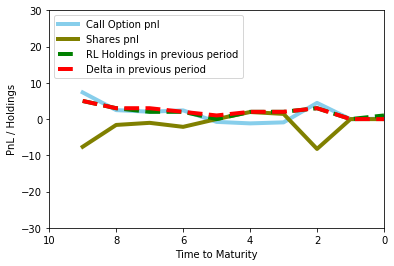

In [8]:
# Plot the pnl breakdown for the last path in test phase

# Create dataframe for plotting
df=pd.DataFrame({'Time to Maturity': ttm[1:], 'Call Option pnl': -all_call_option_pnl[-1,:], 'Shares pnl': all_shares_pnl[-1,:], 'RL Holdings': position_list[:-1], 'Delta': bsdelta[:-1]})
 
# Multiple line plot
plt.plot( 'Time to Maturity', 'Call Option pnl', data=df, marker='', color='skyblue', linewidth=4)
plt.plot( 'Time to Maturity', 'Shares pnl', data=df, marker='', color='olive', linewidth=4)
plt.plot( 'Time to Maturity', 'RL Holdings', data=df, marker='', color='green', linewidth=4, linestyle='dashed')
plt.plot( 'Time to Maturity', 'Delta', data=df, marker='', color='red', linewidth=4, linestyle='dashed')

# Add legend
plt.legend()
plt.legend(['Call Option pnl', 'Shares pnl', 'RL Holdings in previous period', 'Delta in previous period'], loc='upper left')

# Set x and y axis limit
plt.xlim(10,0)
plt.ylim(-30,30)
plt.xlim(10,0)

# Add label
plt.ylabel('PnL / Holdings')
plt.xlabel('Time to Maturity')

plt.show()